<a href="https://colab.research.google.com/github/DHANUSHREE2001/BreastCancerProteomes/blob/main/Breast_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,adjusted_mutual_info_score,adjusted_rand_score,homogeneity_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
plt.style.use('seaborn-darkgrid')

In [ ]:
cancer_proteomes = pd.read_csv('https://raw.githubusercontent.com/tabspacecoder/cancerDetection/main/77_cancer_proteomes_CPTAC_itraq.csv',index_col = 0)
breast_cancer = pd.read_csv('https://raw.githubusercontent.com/tabspacecoder/cancerDetection/main/clinical_data_breast_cancer.csv',index_col=0)
pam50_protein  = pd.read_csv('https://raw.githubusercontent.com/tabspacecoder/cancerDetection/main/PAM50_proteins.csv',header = 0)

In [ ]:
cancer_proteomes.head()

,gene_symbol,gene_name,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,C8-A12L.04TCGA,A2-A0EX.04TCGA,AO-A12D.05TCGA,AN-A04A.05TCGA,BH-A0AV.05TCGA,C8-A12T.06TCGA,A8-A06Z.07TCGA,A2-A0CM.07TCGA,BH-A18U.08TCGA,A2-A0EQ.08TCGA,AR-A0U4.09TCGA,AO-A0J9.10TCGA,AR-A1AP.11TCGA,AN-A0FK.11TCGA,AO-A0J6.11TCGA,A7-A13F.12TCGA,BH-A0E1.12TCGA,A7-A0CE.13TCGA,A2-A0YC.13TCGA,AO-A0JC.14TCGA,A8-A08Z.14TCGA,AR-A0TX.14TCGA,A8-A076.15TCGA,AO-A126.15TCGA,BH-A0C1.16TCGA,A2-A0EY.16TCGA,AR-A1AW.17TCGA,AR-A1AV.17TCGA,C8-A135.17TCGA,A2-A0EV.18TCGA,AN-A0AM.18TCGA,...,AO-A0JJ.20TCGA,AO-A0JE.21TCGA,AN-A0AJ.21TCGA,A7-A0CJ.22TCGA,AO-A12F.22TCGA,A8-A079.23TCGA,A2-A0T3.24TCGA,A2-A0YD.24TCGA,AR-A0TR.25TCGA,AO-A03O.25TCGA,AO-A12E.26TCGA,A8-A06N.26TCGA,A2-A0YG.27TCGA,BH-A18N.27TCGA,AN-A0AL.28TCGA,A2-A0T6.29TCGA,E2-A158.29TCGA,E2-A15A.29TCGA,AO-A0JM.30TCGA,C8-A12V.30TCGA,A2-A0D2.31TCGA,C8-A12U.31TCGA,AR-A1AS.31TCGA,A8-A09G.32TCGA,C8-A131.32TCGA,C8-A134.32TCGA,A2-A0YF.33TCGA,BH-A0DD.33TCGA,BH-A0E9.33TCGA,AR-A0TT.34TCGA,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NP_958782,PLEC,plectin isoform 1,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,1.185108,1.100688,0.384588,0.350536,-0.204918,-0.496409,0.683404,-0.265030,-0.912670,-0.033221,0.020007,0.461088,0.973564,0.831132,1.279185,0.762044,-1.123173,0.818824,-0.307267,0.568895,-0.583429,1.873982,0.195877,-0.518366,1.174881,0.578309,-0.759823,1.120502,0.452986,1.501967,...,0.757188,0.559777,-0.428181,-1.00124,-1.947792,1.048959,0.583713,0.063779,-1.101675,1.053225,0.264859,0.238547,-0.078202,1.101261,0.323663,0.793976,-1.086529,2.180123,1.395247,0.673905,0.107491,-0.481550,1.222507,-1.523343,2.707250,0.140182,0.311319,-0.692316,1.466665,-0.511421,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,NaN,plectin isoform 1g,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,1.192612,1.100688,0.371393,0.367405,-0.162418,-0.498509,0.694424,-0.251642,-0.927979,-0.030216,0.011955,0.461088,0.977476,0.856540,1.275167,0.762044,-1.123173,0.814877,-0.307267,0.568895,-0.572549,1.870383,0.195877,-0.510002,1.183209,0.582213,-0.759823,1.137618,0.472590,1.510348,...,0.780871,0.563407,-0.406378,-1.00462,-1.952718,1.052257,0.580623,0.093336,-1.108783,1.055948,0.275711,0.249818,-0.068058,1.101261,0.326973,0.818182,-1.095492,2.180123,1.408922,0.688718,0.104164,-0.477890,1.218974,-1.512646,2.733832,0.126054,0.296177,-0.659469,1.482283,-0.526067,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,PLEC,plectin isoform 1a,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,1.188860,1.100688,0.371393,0.367405,-0.166668,-0.496409,0.698098,-0.251642,-0.927979,-0.027212,0.011955,0.461088,0.977476,0.856540,1.275167,0.766384,-1.116861,0.814877,-0.307267,0.568895,-0.567109,1.870383,0.195877,-0.507214,1.183209,0.578309,-0.749114,1.137618,0.472590,1.501967,...,0.774104,0.559777,-0.406378,-1.00462,-1.955180,1.052257,0.580623,0.084469,-1.108783,1.055948,0.275711,0.244183,-0.071439,1.097767,0.326973,0.814724,-1.095492,2.180123,1.412341,0.688718,0.107491,-0.481550,1.222507,-1.509972,2.737629,0.133118,0.296177,-0.664161,1.474474,-0.526067,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,NaN,plectin isoform 1c,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,1.185108,1.100688,0.377990,0.360657,-0.183668,-0.492209,0.687077,-0.251642,-0.931806,-0.030216,0.003904,0.461088,0.969652,0.836778,1.279185,0.757704,-1.129486,0.799090,-0.307267,0.568895,-0.583429,1.859587,0.218935,-0.518366,1.174881,0.590021,-0.735727,1.137618,0.458587,1.501967,...,0.763955

In [ ]:
cancer_proteomes.shape

(12553, 85)

In [ ]:
breast_cancer.head()

,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,Metastasis-Coded,AJCC Stage,Converted Stage,Survival Data Form,Vital Status,Days to Date of Last Contact,Days to date of Death,OS event,OS Time,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0T2,FEMALE,66,Negative,Negative,Negative,T3,T_Other,N3,Positive,M1,Positive,Stage IV,No_Conversion,followup,DECEASED,240,240.0,1,240,Basal-like,0,-13,3,5,Basal,3,2,2,2
TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,Negative,Stage IIA,Stage IIA,followup,DECEASED,754,754.0,1,754,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-BH-A18V,FEMALE,48,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,Negative,Stage IIB,No_Conversion,enrollment,DECEASED,1555,1555.0,1,1555,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,Negative,Stage IIB,No_Conversion,enrollment,DECEASED,1692,1692.0,1,1692,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A0E0,FEMALE,38,Negative,Negative,Negative,T3,T_Other,N3,Positive,M0,Negative,Stage IIIC,No_Conversion,followup,LIVING,133,NaN,0,133,Basal-like,0,-13,5,5,Basal,1,2,2,2


In [ ]:
breast_cancer.shape

(105, 29)

In [ ]:
pam50_protein.head()

,GeneSymbol,RefSeqProteinID,Species,Gene Name
0,MIA,NP_006524,Homo sapiens,melanoma inhibitory activity
1,FGFR4,NP_002002,Homo sapiens,fibroblast growth factor receptor 4
2,FGFR4,NP_998812,Homo sapiens,fibroblast growth factor receptor 4
3,FGFR4,NP_075252,Homo sapiens,fibroblast growth factor receptor 4
4,GPR160,NP_055188,Homo sapiens,G protein-coupled receptor 160


In [ ]:
pam50_protein.shape

(100, 4)

#Creating a dataframe by removing gene_symbol and gene_name attributes in cancer_proteomes

In [ ]:
proteomes = cancer_proteomes.drop(['gene_symbol','gene_name'], axis=1)

#Matching patient ID between datasets

In [ ]:
import sklearn, re

In [ ]:
proteomes.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)
proteomes = proteomes.transpose()

In [ ]:
proteomes.head()

RefSeq_accession_number,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,NP_076965,NP_001367,NP_036222,NP_001138241,NP_001714,NP_002464,NP_001073936,NP_061198,NP_001074248,NP_001074419,NP_056009,NP_036355,NP_001155291,NP_002462,NP_000248,NP_036467,NP_004989,NP_001243024,NP_149043,NP_067047,NP_002461,NP_060003,NP_003793,NP_060004,NP_005954,NP_002463,NP_689914,NP_001242941,NP_060227,NP_055796,...,NP_061841,NP_001014979,NP_848561,NP_000331,NP_690591,XP_003960234,NP_000237,NP_057387,NP_004187,NP_065087,NP_004953,NP_001034806,NP_065119,NP_110392,NP_620138,NP_062558,NP_001005163,NP_665813,NP_005279,NP_998761,YP_003024032,NP_001165887,NP_001010893,NP_872303,NP_000871,NP_690872,NP_683762,NP_060064,NP_699174,NP_001164045,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494
TCGA-AO-A12D,1.096131,1.111370,1.111370,1.107561,1.115180,1.107561,1.111370,1.111370,-1.517390,0.482754,0.261785,0.924690,-0.580180,-0.012520,-0.187771,2.044771,-0.065857,-0.351592,0.318932,0.318932,0.970408,1.526638,1.526638,1.111370,-0.507794,0.082725,0.539901,2.101918,0.802777,1.183757,-0.450647,1.035174,0.962788,1.035174,0.962788,1.111370,0.661814,2.098108,1.385676,-0.911632,...,NaN,0.025578,-0.100145,NaN,NaN,-2.881298,NaN,-2.058382,NaN,NaN,NaN,1.275192,0.787538,NaN,NaN,0.825636,1.454252,0.840875,NaN,0.139872,NaN,0.932310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.231655,NaN,NaN,NaN,-0.340163,NaN,NaN,NaN,NaN,-0.633517,12.666488
TCGA-C8-A131,2.609943,2.650422,2.650422,2.646374,2.646374,2.646374,2.650422,2.650422,3.909313,-1.045294,-0.037371,1.399627,-0.134520,0.756014,0.173119,1.593925,-0.875283,-1.021006,-0.438111,-0.438111,1.642499,2.925678,2.925678,-0.616218,1.391531,2.524937,2.184915,0.513141,1.294382,-0.838852,0.768157,1.391531,1.699170,1.233663,2.018952,2.018952,0.169071,0.513141,0.614338,-0.725511,...,NaN,1.691074,0.007156,NaN,NaN,1.079844,NaN,-5.890607,NaN,NaN,NaN,1.314621,0.662912,NaN,NaN,0.136688,1.002934,1.468441,NaN,-0.446207,NaN,1.229616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.279550,NaN,NaN,NaN,3.451902,NaN,NaN,NaN,NaN,4.840325,0.140736
TCGA-AO-A12B,-0.659828,-0.648742,-0.654285,-0.632113,-0.640428,-0.654285,-0.648742,-0.648742,-0.618256,1.222003,1.019685,-1.230752,0.781338,-1.092178,-1.785046,-1.266781,-2.281140,0.016412,0.088470,0.088470,-0.906489,-2.383685,-2.383685,-3.467331,-2.799406,-2.466829,-2.641432,-0.673685,-1.943020,-7.763116,-2.480686,-2.799406,-2.480686,-2.799406,-2.480686,-2.403085,-1.721303,-0.662600,-0.260736,0.116185,...,NaN,-2.863150,-0.593313,NaN,NaN,-1.308353,NaN,-6.413408,NaN,NaN,NaN,0.529134,-1.541157,NaN,NaN,1.887156,-4.900183,-0.837202,NaN,-2.228482,NaN,0.756395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.462290,NaN,NaN,NaN,-1.718531,NaN,NaN,NaN,NaN,-1.965192,-2.854835
TCGA-BH-A18Q,0.195341,0.215413,0.215413,0.205377,0.215413,0.215413,0.215413,0.215413,-1.035760,-0.517226,-0.724639,-0.085671,-0.306467,0.737293,2.041991,1.028341,1.868032,-0.881872,0.780782,0.787473,0.018035,-0.758093,-0.758093,-3.865953,-3.865953,1.924903,1.965048,-0.821655,2.098863,1.101939,-2.397330,-1.567676,-0.597515,-1.567676,-1.567676,-1.340190,0.185305,-0.821655,-1.410443,-7.569291,...,-20.331922,-3.210258,-2.598053,-3.936206,NaN,NaN,-10.680496,-12.028685,3.360072,NaN,-2.159808,-3.414326,NaN,NaN,NaN,2.895064,NaN,NaN,-13.547488,-4.896331,-4.708989,NaN,NaN,-2.865684,0.723911,NaN,NaN,NaN,0.583405,-11.864761,0.048144,NaN,-0.881872,2.527072,-8.111243,-16.029761,-2.046065,-1.778435,NaN,-3.069752
TCGA-C8-A130,-0.494060,-0.503899,-0.500619,-0.510459,-0.503899,-0.503899,-0.500619,-0.500619,-1.845366,-0.405503,-0.703971,-0.785968,-0.917163,-1.133634,-0.520299,0.109436,-0.976200,-1.517379,-0.608855,-0.621974,0.847407,0.555498,0.555498,-0.448141,-0.510459,-0.464541,-0.225110,0.230791,-0.592456,-0.149673,-0.398943,-0.126714,-1.399303,-0.448141,-0.398943,-0.398943,-0.077516,0.234071,-0.349745,0.345587,...,3.425384,-0.041438,0.598137,-0.494060,NaN,NaN,0.460382,-3.678812,1.962562,NaN,1.742811,-1.6190

#Drop clinical entries for samples not in our protein data set

In [ ]:
breast_cancer = breast_cancer.loc[[x for x in breast_cancer.index.tolist() if x in proteomes.index],:]

In [ ]:
breast_cancer

,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,Metastasis-Coded,AJCC Stage,Converted Stage,Survival Data Form,Vital Status,Days to Date of Last Contact,Days to date of Death,OS event,OS Time,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,Negative,Stage IIA,Stage IIA,followup,DECEASED,754,754.0,1,754,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,Negative,Stage IIB,No_Conversion,enrollment,DECEASED,1692,1692.0,1,1692,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-A7-A0CE,FEMALE,57,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,Negative,Stage IIA,Stage IIA,followup,LIVING,309,NaN,0,309,Basal-like,0,-13,5,5,Basal,1,2,2,2
TCGA-D8-A142,FEMALE,74,Negative,Negative,Negative,T3,T_Other,N0,Negative,M0,Negative,Stage IIB,Stage IIB,followup,LIVING,425,NaN,0,425,Basal-like,0,-13,3,5,X,1,2,2,2
TCGA-AO-A0J6,FEMALE,61,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,Negative,Stage IIA,Stage IIA,followup,LIVING,775,NaN,0,775,Basal-like,-12,-13,2,5,Basal,1,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AR-A1AV,MALE,68,Positive,Positive,Negative,T2,T_Other,N1,Positive,M0,Negative,Stage II,Stage IIB,enrollment,LIVING,1295,NaN,0,1295,Luminal B,-5,-2,7,3,LumA/B,3,4,4,5
TCGA-BH-A0C7,FEMALE,48,Positive,Negative,Positive,T2,T_Other,N1,Positive,M0,Negative,Stage IIB,Stage IIB,enrollment,LIVING,1305,NaN,0,1305,Luminal B,-3,0,4,4,LumA/B,5,4,1,3
TCGA-BH-A0DD,MALE,58,Positive,Positive,Positive,T2,T_Other,N1,Positive,M0,Negative,Stage IIB,Stage IIB,enrollment,LIVING,1393,NaN,0,1393,Luminal B,-3,-6,4,4,LumA/B,3,4,1,3


#Merging data for clinical and proteins

In [ ]:
data = proteomes.merge(breast_cancer,left_index=True,right_index=True)

In [ ]:
data.head()

,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,NP_076965,NP_001367,NP_036222,NP_001138241,NP_001714,NP_002464,NP_001073936,NP_061198,NP_001074248,NP_001074419,NP_056009,NP_036355,NP_001155291,NP_002462,NP_000248,NP_036467,NP_004989,NP_001243024,NP_149043,NP_067047,NP_002461,NP_060003,NP_003793,NP_060004,NP_005954,NP_002463,NP_689914,NP_001242941,NP_060227,NP_055796,...,NP_001164045,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,Metastasis-Coded,AJCC Stage,Converted Stage,Survival Data Form,Vital Status,Days to Date of Last Contact,Days to date of Death,OS event,OS Time,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
TCGA-A2-A0CM,0.683404,0.694424,0.698098,0.687077,0.687077,0.698098,0.698098,0.698098,-2.652150,-0.984373,-0.547225,0.654015,-0.672124,-1.436216,-0.150485,-0.308446,0.136049,-1.590504,-0.716207,-0.705186,-1.223152,-1.910100,-1.902753,-1.054170,-1.054170,0.598913,0.867079,-0.701512,1.124226,0.161764,-0.337834,-0.664777,-0.374569,-0.374569,-0.374569,-0.110076,-0.069667,-0.712533,NaN,-0.172526,...,NaN,NaN,NaN,1.153614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,Negative,Stage IIA,Stage IIA,followup,DECEASED,754,754.0,1,754,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-A2-A0D2,0.107491,0.104164,0.107491,0.097512,0.104164,0.104164,0.104164,0.104164,-0.880454,-1.512473,-1.406028,0.077553,0.493355,-0.594383,-0.002281,0.932442,-1.595633,-1.213096,-0.295005,-0.295005,0.436806,-0.361534,-0.408103,1.018928,1.161964,1.218513,2.236396,0.689613,1.391487,-3.162374,1.161964,1.305000,1.018928,1.161964,1.161964,1.018928,-0.677543,0.686287,-4.070485,-1.203116,...,-5.158223,0.919136,-1.648856,0.832649,NaN,-8.324969,-4.679219,NaN,-1.106650,NaN,-6.941181,FEMALE,45,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,Negative,Stage IIB,Stage IIA,followup,LIVING,1027,NaN,0,1027,Basal-like,-12,-13,4,5,Basal,3,2,2,2
TCGA-A2-A0EQ,-0.912670,-0.927979,-0.927979,-0.931806,-0.927979,-0.927979,-0.927979,-0.927979,-3.071151,-2.278943,-2.236845,-0.598849,-1.471426,-1.750804,-2.056971,-1.215011,1.272601,-1.414020,-1.215011,-1.306861,-0.537615,0.974087,0.931989,-1.842654,-1.525005,0.461257,-0.610330,-1.984257,2.382458,0.671747,-1.287726,-1.525005,-1.452291,-1.486734,-1.486734,-1.452291,2.401593,-1.991911,NaN,-0.120462,...,-0.970077,-0.801685,NaN,NaN,3.802310,-6.373934,-1.123160,NaN,NaN,NaN,NaN,FEMALE,64,Negative,Negative,Positive,T2,T_Other,N0,Negative,M0,Negative,Stage IIA,Stage IIA,followup,LIVING,2426,NaN,0,2426,HER2-enriched,-5,-2,5,4,Basal,4,4,1,1
TCGA-A2-A0EV,0.452986,0.472590,0.472590,0.458587,0.472590,0.472590,0.472590,0.472590,-0.742871,1.811277,1.956909,-0.247164,-1.022931,-0.109935,0.024494,0.002089,-1.272184,-0.448808,4.158181,4.107770,1.223151,-0.485215,-0.474013,-2.669684,-2.145972,0.819865,0.881478,-0.247164,1.802876,-0.165947,-3.123381,-2.669684,-2.260796,-2.669684,-2.669684,-2.669684,-0.616844,-0.247164,-0.151944,-1.532640,...,NaN,-4.966177,-1.471027,NaN,-0.474013,-12.278546,-10.337729,-0.653251,NaN,NaN,NaN,FEMALE,80,Positive,Positive,Negative,T1,T1,N0,Negative,M0,Negative,Stage IA,Stage I,followup,LIVING,968,NaN,0,968,Luminal A,-4,0,4,2,ReacI,3,3,3,4
TCGA-A2-A0EX,1.185108,1.192612,1.188860,1.185108,1.200116,1.188860,1.188860,1.192612,1.046289,2.138081,1.732880,0.187113,-0.687070,0.093317,0.734885,1.151341,0.273406,1.725376,1.035034,1.046289,3.586299,0.138339,0.138339,1.515272,1.759143,0.239639,1.372701,2.828423,0.588562,-0.068013,1.275153,2.081803,2.093059,1.995510,1.995510,1.995510,0.903719,2.809664,-1.707576,0.070806,...,NaN,1.451490,-2.018981,0.877456,NaN,NaN,-6.101005,NaN,-1.726336,

In [ ]:
numerical_data = data.loc[:,[x for x in data.columns if bool(re.search("NP_|XP_",x)) == True]]
pam50_data = numerical_data.iloc[:,numerical_data.columns.isin(pam50_protein['RefSeqProteinID'])]

In [ ]:
pam50_data

,NP_057427,NP_002408,NP_000415,NP_000413,NP_000517,NP_004439,NP_005219,NP_058519,NP_058518,NP_001116539,NP_061155,NP_001035932,NP_077006,NP_000917,NP_065178,NP_006836,NP_006614,NP_001784,NP_006092,NP_001153651,NP_001159403,NP_000116,NP_004314,NP_060601,NP_005931,NP_003003,NP_113611,NP_002002,NP_004487,NP_008950,NP_114172,NP_001062,NP_001444,NP_057547,NP_054895,NP_001246,NP_055606,NP_036451,NP_000624,NP_569082,NP_001159,NP_001229,NP_002458
TCGA-A2-A0CM,2.160157,2.623021,4.768355,0.639321,4.933663,-4.419112,-0.271711,-6.013418,-6.013418,-6.318320,2.277710,-4.029719,-4.029719,-6.509343,1.906685,2.215260,-1.601524,1.631171,2.013217,-6.395464,0.584219,-4.937078,-0.433346,3.126292,-1.182743,0.286664,0.980958,1.509945,-4.433806,2.549550,2.733226,0.896468,1.576068,-1.292949,3.541400,3.177722,NaN,-1.792547,NaN,NaN,2.516489,2.556897,NaN
TCGA-A2-A0D2,2.249702,3.576941,2.169868,2.968207,0.543251,-5.421010,-1.206443,-5.297932,-5.277974,-5.311238,2.934943,-5.567372,-5.567372,-5.287953,1.198555,3.264258,2.449287,2.332862,3.606879,-7.124134,-0.853843,-4.153646,-2.417258,-0.604362,2.545753,7.053044,2.921637,3.743262,-6.269245,2.376105,2.781928,6.836827,2.898353,-3.694601,2.495856,2.722053,0.373604,-1.342826,-4.183584,-2.889608,3.487128,NaN,-0.714133
TCGA-A2-A0EQ,-0.020957,1.884936,-7.407249,-7.675146,-5.187535,-2.795601,7.158672,-9.114133,-8.762041,-9.573385,-0.859091,-1.241800,-1.241800,-7.047502,1.961478,0.863101,1.842838,-0.369223,0.266075,-3.055843,-0.836128,-6.308873,-0.686872,0.162743,-2.791774,-5.554936,0.047930,3.388984,0.063239,0.545453,-0.273546,1.460128,NaN,-1.410193,0.702364,-1.402538,NaN,NaN,1.934688,NaN,0.798041,2.003576,NaN
TCGA-A2-A0EV,-1.364604,-2.246793,-3.750716,-3.882344,-2.252395,-3.252209,-1.574649,-2.190781,-2.871327,-2.190781,-4.632905,-2.608071,-2.608071,-1.266583,1.158737,-2.039549,-1.160160,-1.216172,-1.185366,0.466989,-1.924724,0.649028,-0.488016,-6.134027,0.534203,1.080321,-0.709263,-1.199369,-1.723081,-2.179579,-3.311022,0.139319,0.733046,0.018893,-1.574649,-4.515280,NaN,NaN,2.049328,NaN,-0.266769,-3.201798,-7.724769
TCGA-A2-A0EX,-2.506723,-2.953194,-0.803378,-2.315378,-0.098028,-1.643795,-1.212331,4.186597,3.976493,3.942726,-2.521730,0.427232,0.415977,1.545287,1.725376,-1.812629,-2.476708,-0.923438,-1.966455,-2.037740,-1.973959,-2.409174,0.115828,-0.882167,0.419729,1.031282,-1.666306,-0.083021,-0.281869,-3.752341,-3.317125,-2.769353,NaN,-0.822137,-2.938187,-3.395914,-1.827636,0.082061,0.044543,-2.079011,-3.046991,2.554537,-0.443199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-C8-A138,-0.409316,0.739026,0.943825,1.415596,1.806910,-0.504402,-2.625542,-5.284283,-4.907597,-5.309883,1.272968,0.329426,0.329426,-3.207028,0.523254,-1.634458,-1.440629,1.232739,0.014912,-1.510115,-0.668973,-3.693427,0.219712,0.567140,0.735368,-3.748284,-0.690916,-0.105774,0.618340,-0.178916,-0.610459,-0.153316,2.461538,-0.248402,-0.295945,-2.307371,4.641193,-1.799029,NaN,NaN,-2.076972,-0.851830,1.554568
TCGA-D8-A142,-0.415696,-1.232627,-2.823113,1.724231,0.668726,-3.130366,-0.462687,-6.427009,-6.195666,-6.427009,-1.529036,-5.530553,-5.530553,-6.394476,0.813316,-1.778453,1.496502,2.721899,0.065065,-5.244989,-0.592818,-3.065300,-1.619404,-3.867773,0.621735,0.397621,-0.086754,7.757232,-3.990674,-0.726563,-1.467585,-1.456741,2.049557,-2.320664,-1.232627,-1.438667,NaN,NaN,-0.910915,NaN,-0.075910,-0.101213,-7.659635
TCGA-E2-A154,-2.742664,-3.307172,-5.903908,-5.218972,-4.650701,-3.894260,-3.284592,2.861017,3.098110,2.981445,-2.061491,-0.710436,-0.710436,4.415295,0.226647,-2.622236,-4.184041,-1.214730,-2.012567,6.989451,-1.579778,1.735765,3.327677,-1.820635,-0.243776,-0.879788,-4.522746,1.223944,1.235234,-1.463113,-3.860390,-0.620115,-6.615188,-0.202379,-2.772771,-6.268957,1.340609,1.826086,NaN,NaN,0.395999,-3.962001,-7.804418
TCGA-E2-A158,-0.781777,-1.588474,-3.732945,0.701651,0.213150,-2.531862,-0.277591,-4.456

#FILLING MISSING VALUES USING KNN

In [ ]:
Imputer = KNNImputer()
dta = Imputer.fit_transform(pam50_data)

In [ ]:
pam50 = pd.DataFrame(dta,columns=pam50_data.columns)
pam50.index=pam50_data.index

In [ ]:
pam50.isnull().sum()

NP_057427       0
NP_002408       0
NP_000415       0
NP_000413       0
NP_000517       0
NP_004439       0
NP_005219       0
NP_058519       0
NP_058518       0
NP_001116539    0
NP_061155       0
NP_001035932    0
NP_077006       0
NP_000917       0
NP_065178       0
NP_006836       0
NP_006614       0
NP_001784       0
NP_006092       0
NP_001153651    0
NP_001159403    0
NP_000116       0
NP_004314       0
NP_060601       0
NP_005931       0
NP_003003       0
NP_113611       0
NP_002002       0
NP_004487       0
NP_008950       0
NP_114172       0
NP_001062       0
NP_001444       0
NP_057547       0
NP_054895       0
NP_001246       0
NP_055606       0
NP_036451       0
NP_000624       0
NP_569082       0
NP_001159       0
NP_001229       0
NP_002458       0
dtype: int64

# Scaling the data

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# scaling the data
# scaling the data
scaler=StandardScaler()
scaled_proteome=scaler.fit_transform(pam50)
scaled_proteome=pd.DataFrame(scaled_proteome)
scaled_proteome.columns=pam50.columns

In [ ]:
scaled_proteome.index=pam50.index

In [ ]:
scaled_proteome.shape

(80, 43)

# Removal of outliers

In [ ]:
from scipy import stats

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 11.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 17.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; yo

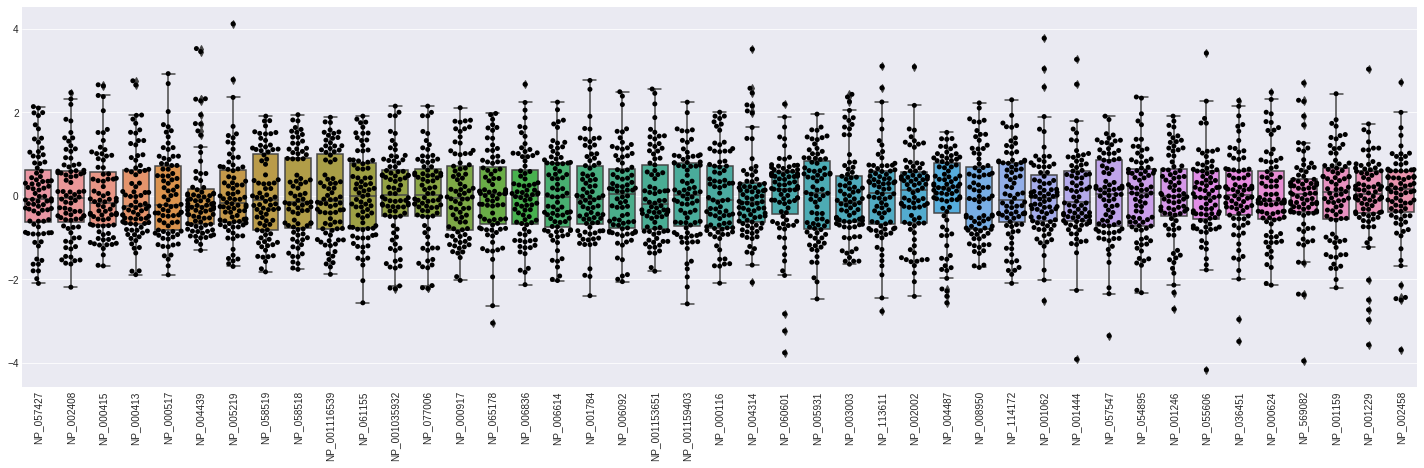

In [ ]:
plt.figure(figsize=(25,7))
sns.swarmplot(data=scaled_proteome,color='black')
sns.boxplot(data=scaled_proteome)
plt.xticks(rotation=90);

In [ ]:
scaled_proteome.head()

,NP_057427,NP_002408,NP_000415,NP_000413,NP_000517,NP_004439,NP_005219,NP_058519,NP_058518,NP_001116539,NP_061155,NP_001035932,NP_077006,NP_000917,NP_065178,NP_006836,NP_006614,NP_001784,NP_006092,NP_001153651,NP_001159403,NP_000116,NP_004314,NP_060601,NP_005931,NP_003003,NP_113611,NP_002002,NP_004487,NP_008950,NP_114172,NP_001062,NP_001444,NP_057547,NP_054895,NP_001246,NP_055606,NP_036451,NP_000624,NP_569082,NP_001159,NP_001229,NP_002458
TCGA-A2-A0CM,1.915429,1.787003,2.368701,0.956765,2.681554,-0.857792,0.685045,-1.013190,-1.010000,-1.054019,1.318018,-1.536634,-1.530853,-1.205899,1.561924,1.862671,-0.457991,0.995306,1.382665,-1.187382,0.866178,-1.204201,-0.145864,2.190874,-0.430323,0.199716,0.617069,0.474590,-1.727568,1.556960,1.648551,0.550058,0.588652,-0.346173,2.334429,1.902432,0.617985,-0.711342,-1.119112,-0.422625,1.816877,1.093266,0.435352
TCGA-A2-A0D2,1.986780,2.311498,1.506565,1.729965,0.891843,-1.169229,0.253719,-0.825051,-0.815685,-0.796065,1.637343,-2.232682,-2.225107,-0.874505,0.814579,2.665268,1.257718,1.379789,2.381862,-1.371510,-0.140688,-0.930750,-1.356531,0.001187,1.563515,2.251232,1.812531,1.408313,-2.568565,1.466709,1.676264,3.768761,1.316990,-1.601894,1.696896,1.679550,0.314490,-0.489684,-2.105053,-2.375811,2.439206,-0.108387,0.622931
TCGA-A2-A0EQ,0.177486,1.381181,-1.670971,-1.803676,-1.444259,-0.353128,4.113748,-1.828531,-1.736225,-1.887770,-0.206036,-0.274628,-0.272101,-1.351916,1.619751,0.828123,1.000858,-0.100788,0.287238,-0.343493,-0.128286,-1.683015,-0.300576,0.451435,-1.290763,-1.571413,0.042322,1.260193,0.332974,0.514137,-0.062423,0.855470,0.503790,-0.407475,0.603292,-0.337918,0.936447,0.191460,1.559519,-0.780609,0.715087,0.747874,0.171267
TCGA-A2-A0EV,-0.893151,-0.890573,-0.457791,-0.544449,-0.247776,-0.495064,0.083812,-0.008017,-0.179814,0.003208,-2.039592,-0.893097,-0.888976,0.216596,0.772556,-1.392718,-0.271053,-0.564865,-0.622789,0.546692,-0.890472,0.745584,-0.179226,-3.244420,0.487826,0.440347,-0.424111,-0.658141,-0.485516,-0.903821,-1.790870,0.139808,0.124300,0.339732,-0.785145,-1.860459,-0.727017,-1.315828,1.628183,0.300170,0.032381,-2.501402,-2.469512
TCGA-A2-A0EX,-1.803208,-1.278974,0.520089,-0.024209,0.630432,0.004907,0.251002,1.668931,1.629478,1.574243,-1.013851,0.480892,0.476389,0.979529,1.370575,-1.219099,-0.828672,-0.404464,-1.112517,-0.086229,-0.924944,-0.321857,0.189265,-0.161870,0.426609,0.425479,-1.013651,-0.191410,0.174846,-1.722200,-1.794343,-1.436216,0.234640,-0.100006,-1.616579,-1.312941,-1.283769,0.212612,0.427406,-1.597799,-1.750170,1.091793,0.742442


In [ ]:
z = np.abs(stats.zscore(scaled_proteome))
threshold=4
z_bool=np.all(z<threshold,axis=0)
scaled_proteome=scaled_proteome.loc[:,z_bool]

In [ ]:
scaled_proteome.shape # dataset after scaling and removing outliers
scaled_proteome_lst=scaled_proteome.columns.tolist()

In [ ]:
scaled_proteome.shape

(80, 41)

# Visualization


Correlation (heat map)

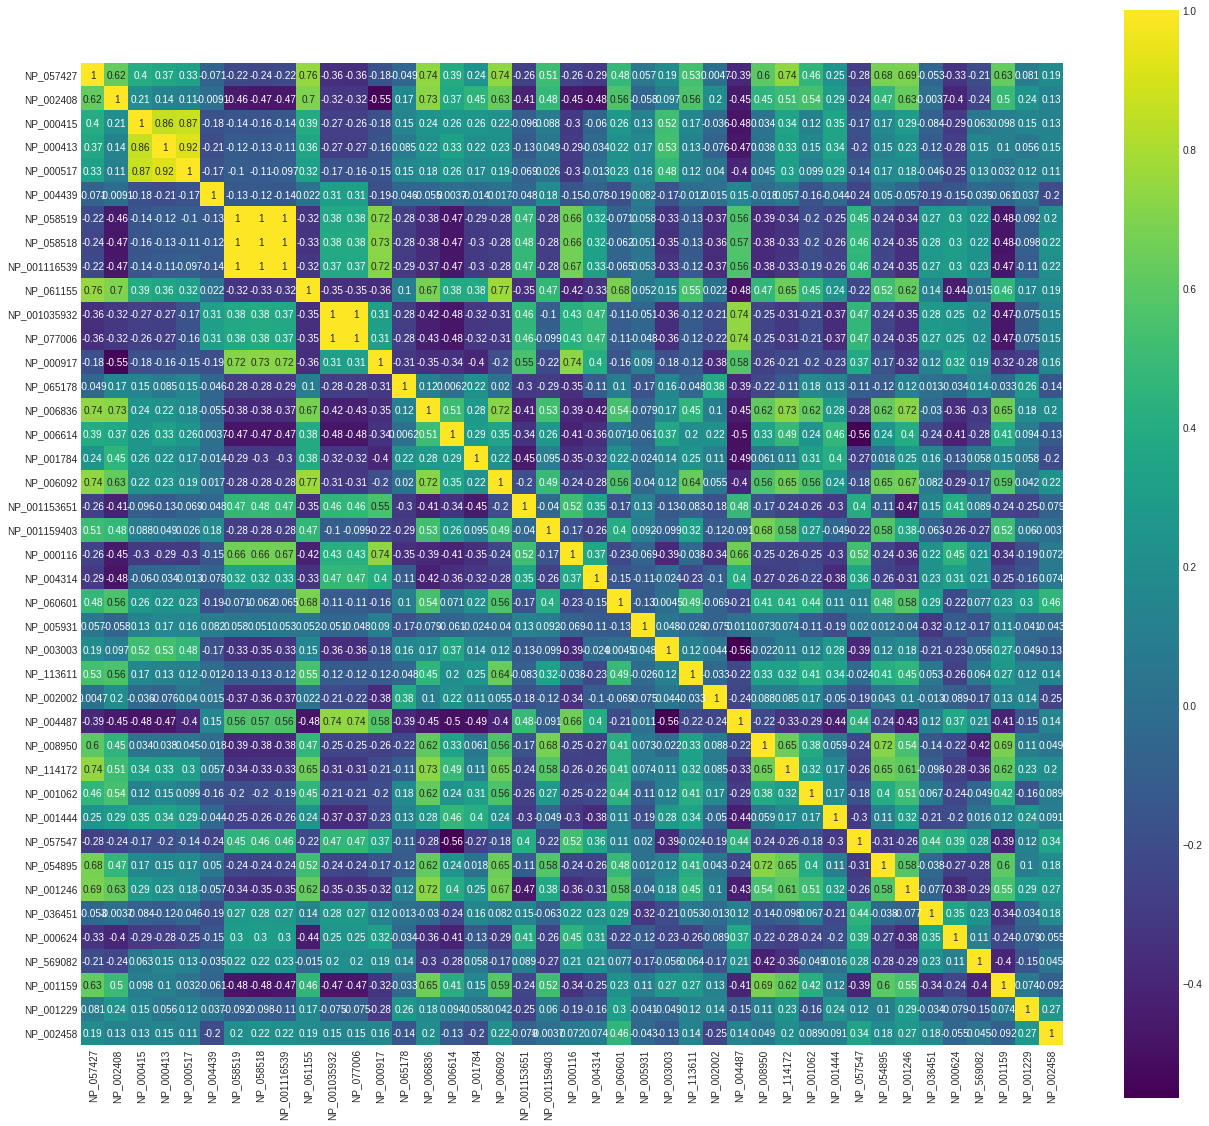

In [ ]:
correlation = scaled_proteome.corr()
plt.figure(figsize=(22,20))
sns.heatmap(correlation, square=True, annot=True, cmap='viridis');

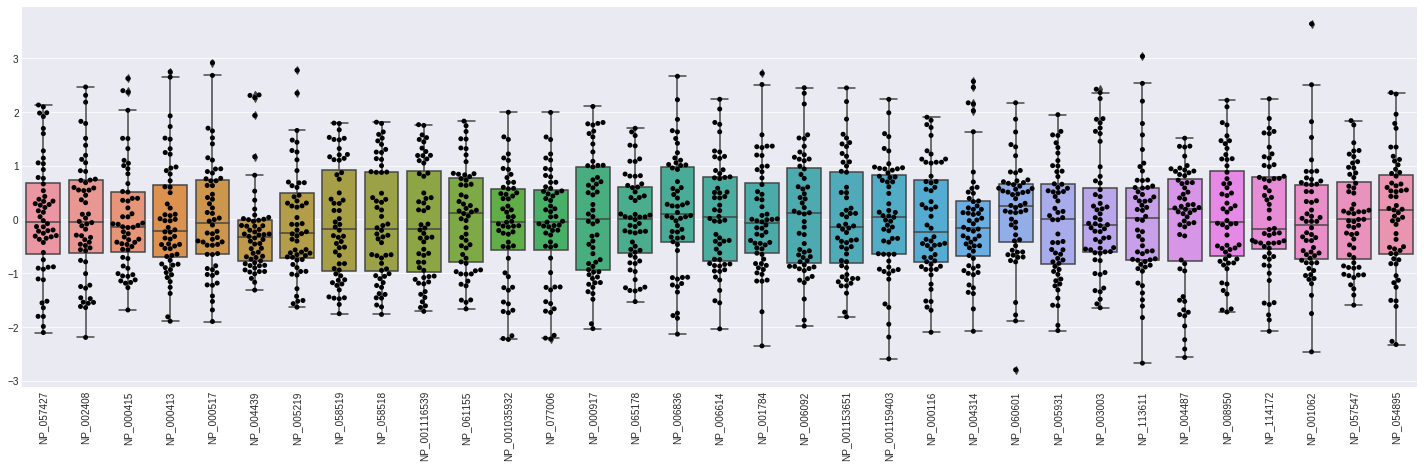

In [ ]:
plt.figure(figsize=(25,7))
sns.swarmplot(data=scaled_proteome,color='black')
sns.boxplot(data=scaled_proteome)
plt.xticks(rotation=90);

*   very few protein values are present in the extremes

*   majority of the values for every column is present in the median(0)

*   there is no uniform declination or inclination in the values(not uniformly distributed)


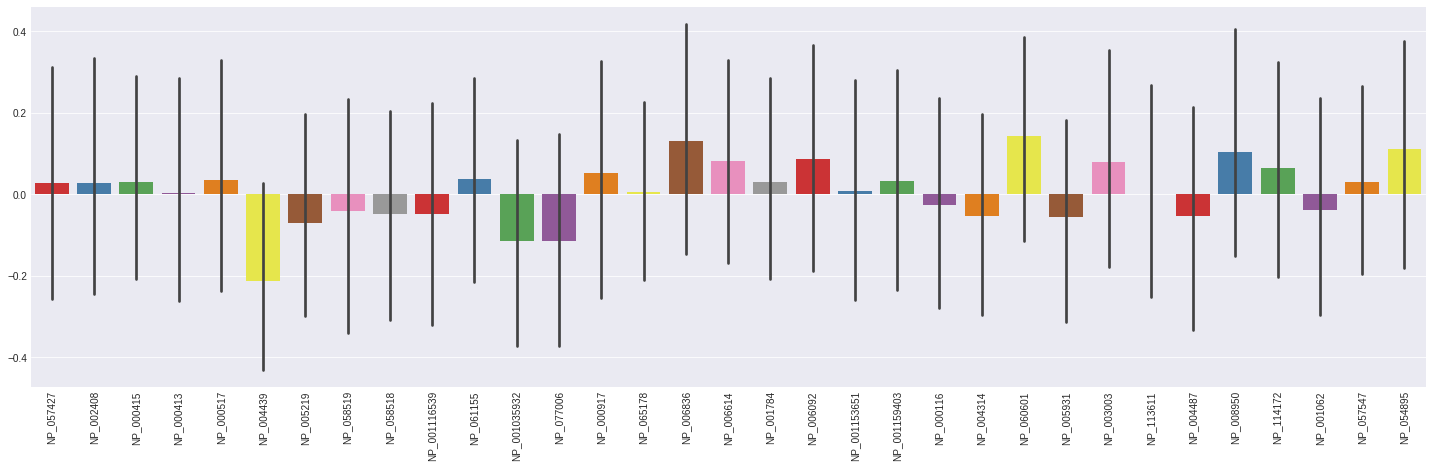

In [ ]:
plt.figure(figsize=(25,7))
sns.barplot(data=scaled_proteome,palette='Set1')
plt.xticks(rotation=90);

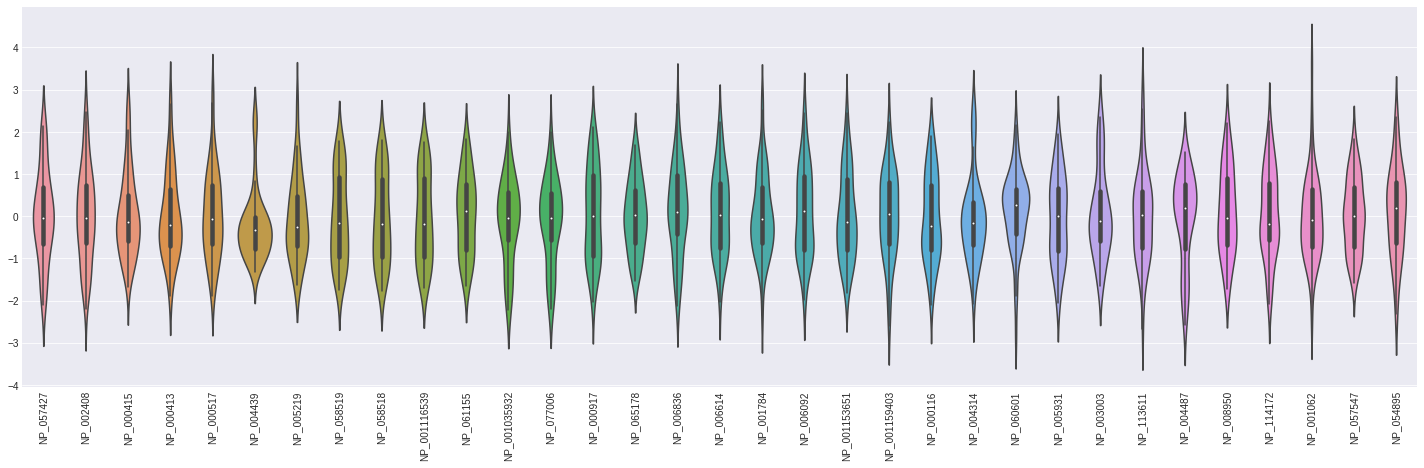

In [ ]:
score=[4,3,2,1,0,-1,-2,-3,-4]
plt.figure(figsize=(25,7))
sns.violinplot(data=scaled_proteome)
plt.xticks(rotation=90);
plt.yticks(score);

*   median , 25th and 75th percentile of every protien vary for a very small range

*   most of the protein values lie between -2 and 2. and a very few between -3 and 3 



([<matplotlib.axis.YTick at 0x7f3701f66ad0>,
 <a list of 9 Text major ticklabel objects>)

<Figure size 1800x504 with 0 Axes>

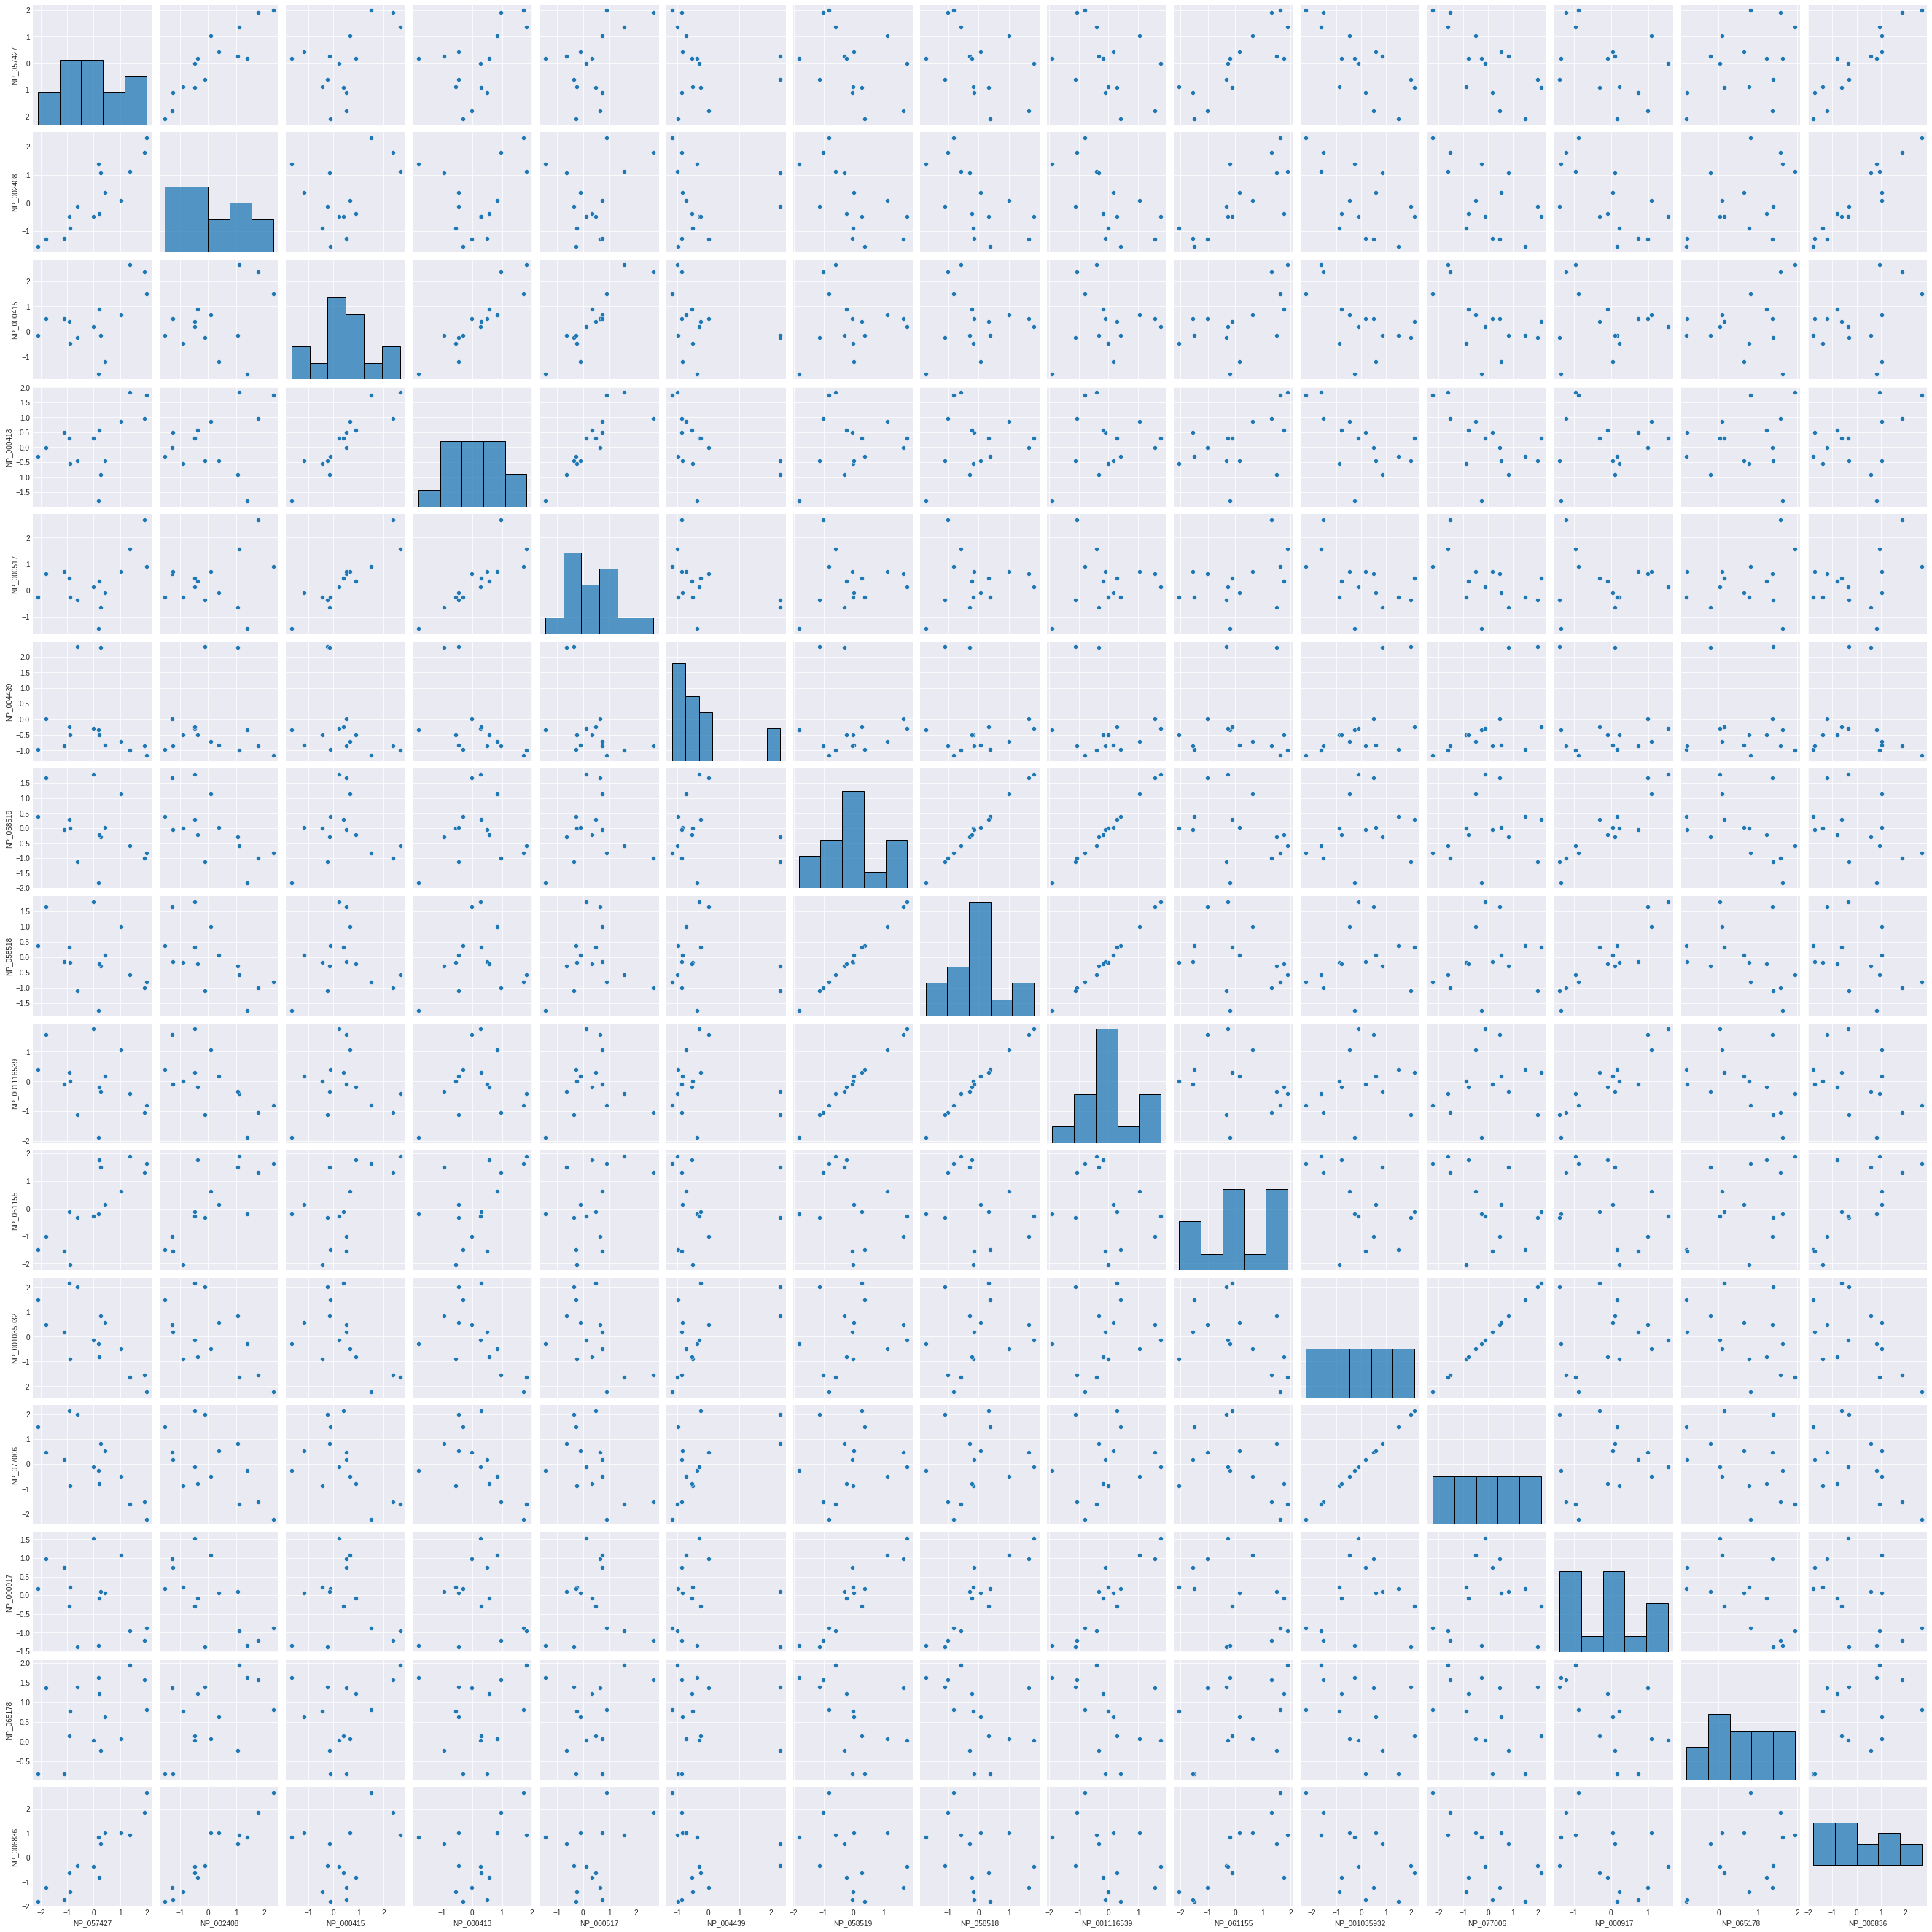

In [ ]:
plt.figure(figsize=(25,7))
df=scaled_proteome.iloc[0:15,0:15]
sns.pairplot(df)
plt.xticks(rotation=90);
score=[4,3,2,1,0,-1,-2,-3,-4]
plt.yticks(score)

#**UNSUPERVISED LEARNING**

# MODELLING WITH KMEANS CLUSTERING

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,adjusted_mutual_info_score,adjusted_rand_score,homogeneity_score

In [ ]:
n_clusters = [2,3,4,5,6,7,8,10,15,27,40]

def compare_k_means(k_list,df):
    ## Run clustering with different k and check the metrics
    for k in k_list:
        clusterer = KMeans(n_clusters=k,max_iter=5000)
        clusterer.fit(df)
        ## The higher (up to 1) the better
        print("Silhouette Coefficient for k == %s: %s" % (
        k, round(silhouette_score(df, clusterer.labels_), 4)))
        ## The higher (up to 1) the better
        print("Homogeneity score for k == %s: %s" % (
        k, round(homogeneity_score(data['PAM50 mRNA'], clusterer.labels_),4)))
        print("Adjusted Rand score for k == %s: %s" % (
        k, round(adjusted_rand_score(data['PAM50 mRNA'], clusterer.labels_),4)))
        print("Average for k == %s: %s" % (
        k, round((homogeneity_score(data['PAM50 mRNA'], clusterer.labels_)+adjusted_rand_score(data['PAM50 mRNA'], clusterer.labels_)+silhouette_score(df, clusterer.labels_))/3,4)))
        print("------------------------")

In [ ]:
compare_k_means(n_clusters,scaled_proteome)

Silhouette Coefficient for k == 2: 0.1593
Homogeneity score for k == 2: 0.1751
Adjusted Rand score for k == 2: 0.1953
Average for k == 2: 0.1766
------------------------
Silhouette Coefficient for k == 3: 0.1417
Homogeneity score for k == 3: 0.4372
Adjusted Rand score for k == 3: 0.4258
Average for k == 3: 0.3349
------------------------
Silhouette Coefficient for k == 4: 0.1405
Homogeneity score for k == 4: 0.4749
Adjusted Rand score for k == 4: 0.4355
Average for k == 4: 0.3503
------------------------
Silhouette Coefficient for k == 5: 0.1293
Homogeneity score for k == 5: 0.5109
Adjusted Rand score for k == 5: 0.4587
Average for k == 5: 0.3663
------------------------
Silhouette Coefficient for k == 6: 0.099
Homogeneity score for k == 6: 0.5484
Adjusted Rand score for k == 6: 0.3227
Average for k == 6: 0.3233
------------------------
Silhouette Coefficient for k == 7: 0.1026
Homogeneity score for k == 7: 0.4908
Adjusted Rand score for k == 7: 0.301
Average for k == 7: 0.2981
-------

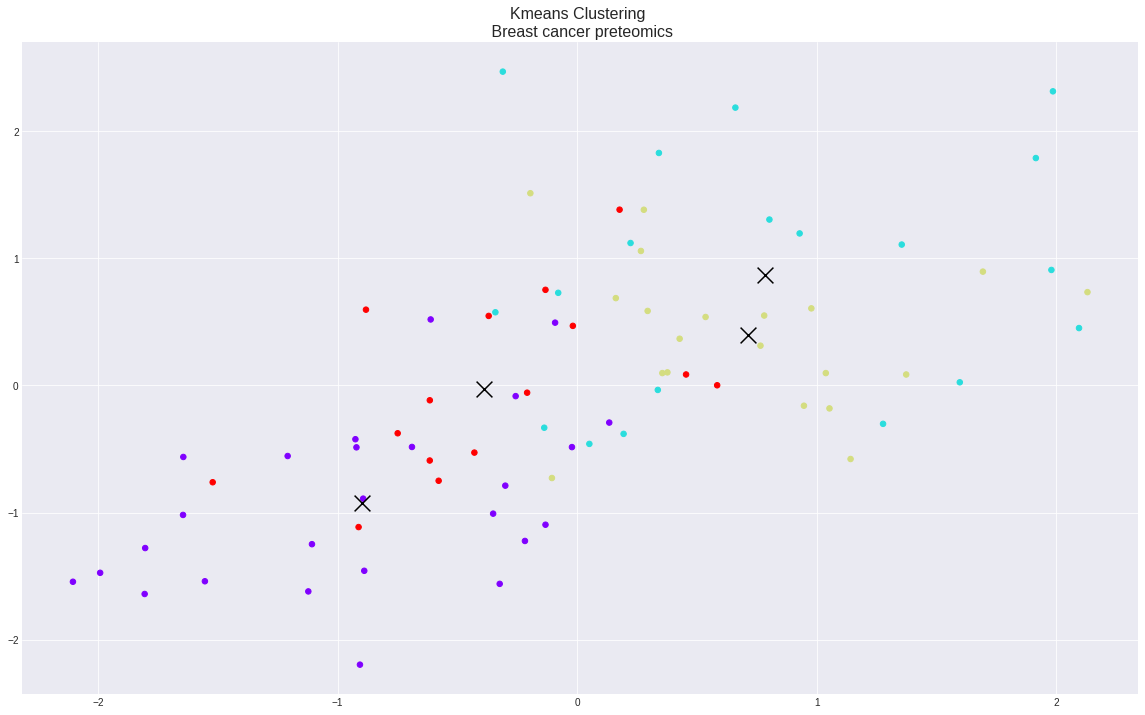

In [ ]:
clusterer_final = KMeans(n_clusters=4)
clusterer_final = clusterer_final.fit(scaled_proteome)
processed_p50_plot = pd.DataFrame(scaled_proteome)
processed_p50_plot['KMeans_cluster'] = clusterer_final.labels_
processed_p50_plot.sort_values('KMeans_cluster',axis=0,inplace=True)
fig = plt.figure(figsize=(20,12))
plt.scatter(scaled_proteome.iloc[:,0], scaled_proteome.iloc[:,1], c=clusterer_final.labels_, cmap="rainbow", s=30)
plt.scatter(clusterer_final.cluster_centers_[:,0] ,clusterer_final.cluster_centers_[:,1], color='black', marker="x", s=250)
plt.title("Kmeans Clustering \n Breast cancer preteomics", fontsize=16)
plt.show()

#DIMENTIONALITY REDUCTION - PCA

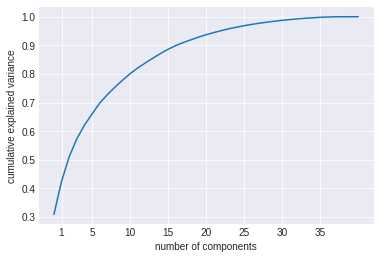

In [ ]:
pca = PCA().fit(scaled_proteome)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks([1,5,10,15,20,25,30,35])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
for n_component in range(10,20,1):
    pca = PCA(n_components=n_component)
    reduced_data = pca.fit_transform(scaled_proteome)
    print('\nComponents: {}'.format(n_component))
    print('% of Variance Explained: {}'.format(sum(pca.explained_variance_ratio_)))
    compare_k_means(n_clusters, reduced_data)


Components: 10
% of Variance Explained: 0.777942955352665
Silhouette Coefficient for k == 2: 0.2061
Homogeneity score for k == 2: 0.1865
Adjusted Rand score for k == 2: 0.2019
Average for k == 2: 0.1981
------------------------
Silhouette Coefficient for k == 3: 0.1989
Homogeneity score for k == 3: 0.4779
Adjusted Rand score for k == 3: 0.4594
Average for k == 3: 0.3787
------------------------
Silhouette Coefficient for k == 4: 0.2001
Homogeneity score for k == 4: 0.4749
Adjusted Rand score for k == 4: 0.4355
Average for k == 4: 0.3702
------------------------
Silhouette Coefficient for k == 5: 0.1701
Homogeneity score for k == 5: 0.5134
Adjusted Rand score for k == 5: 0.3845
Average for k == 5: 0.356
------------------------
Silhouette Coefficient for k == 6: 0.1727
Homogeneity score for k == 6: 0.5335
Adjusted Rand score for k == 6: 0.3766
Average for k == 6: 0.3609
------------------------
Silhouette Coefficient for k == 7: 0.1635
Homogeneity score for k == 7: 0.5634
Adjusted Rand

In [ ]:
pca=PCA(n_components=15)
ProteomicsX_pca=pca.fit(scaled_proteome)
ProteomicsX_pca2=ProteomicsX_pca.transform(scaled_proteome)
print(pca.explained_variance_ratio_)

[0.30945926 0.1151605  0.08568739 0.06272519 0.04787228 0.03896419
 0.03802212 0.02930712 0.02628757 0.02445735 0.0228038  0.02009591
 0.01752375 0.01673973 0.01631209]


In [ ]:
n_clusters = 4
KMeansModel=KMeans(n_clusters=n_clusters, init='k-means++')
KMeanData=ProteomicsX_pca2
KMeansModel.fit(KMeanData)
labels=KMeansModel.labels_
centroids=KMeansModel.cluster_centers_
print("LABELS",labels)
print("----------------------------")
print("Centroids",centroids)

LABELS [3 3 0 1 1 0 2 3 2 1 1 1 1 2 3 3 2 2 1 2 0 2 1 0 1 2 3 0 1 3 2 1 1 1 0 1 3
 0 1 1 1 0 0 2 3 1 0 2 0 3 1 1 2 1 3 1 3 2 2 0 2 1 1 3 0 3 2 2 3 0 2 3 3 3
 0 0 3 1 0 0]
----------------------------
Centroids [[ 0.14054353 -1.49880826 -1.82738195 -0.05543771 -1.10475611 -0.47413246
  -0.27791143 -0.17749103  0.01491013 -0.10476635 -0.11649669 -0.24237263
   0.03945467  0.12050971 -0.02425792]
 [-3.99836658 -0.18941156  0.98158496 -0.17813687  0.25357581  0.03141073
   0.02613126  0.0841729  -0.10518771 -0.02213184  0.09385063  0.09915486
  -0.03556667 -0.02286093  0.02748322]
 [ 0.43514297  2.74237714 -0.69001862  0.71031848  0.14209498  0.18228125
  -0.01576885  0.05282184  0.14216412  0.18605896  0.05534876 -0.01241448
  -0.02349774  0.0116698   0.15753809]
 [ 4.71562145 -0.92889215  1.09334665 -0.38602273  0.57834237  0.2351607
   0.24384018  0.00735383 -0.0104023  -0.04789321 -0.06555806  0.11091035
   0.03168115 -0.09514253 -0.16242756]]


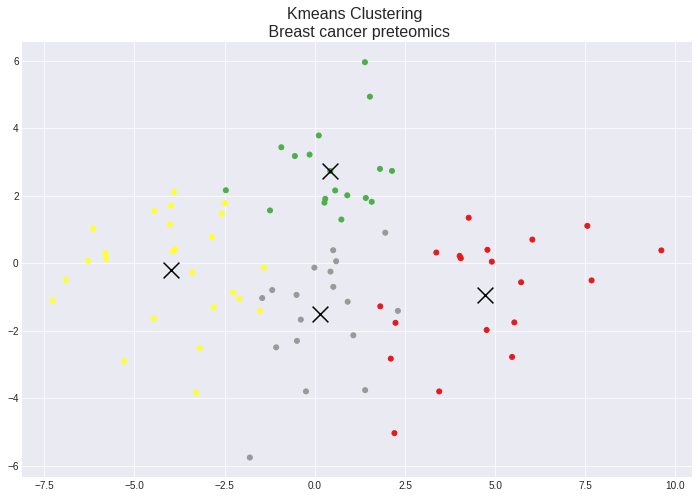

In [ ]:
fig = plt.figure(figsize=(12,8))

plt.scatter(KMeanData[:,0], KMeanData[:,1], c=KMeansModel.labels_, cmap="Set1_r", s=25)
plt.scatter(KMeansModel.cluster_centers_[:,0] ,KMeansModel.cluster_centers_[:,1], color='black', marker="x", s=250)
plt.title("Kmeans Clustering \n Breast cancer preteomics", fontsize=16)
plt.show()

#MODELLING WITH HEIRARCHICAL CLUSTERING (Before Dimentionality Reduction)

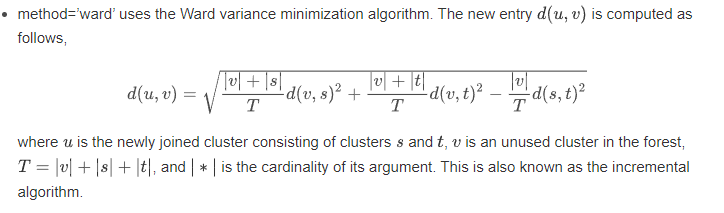

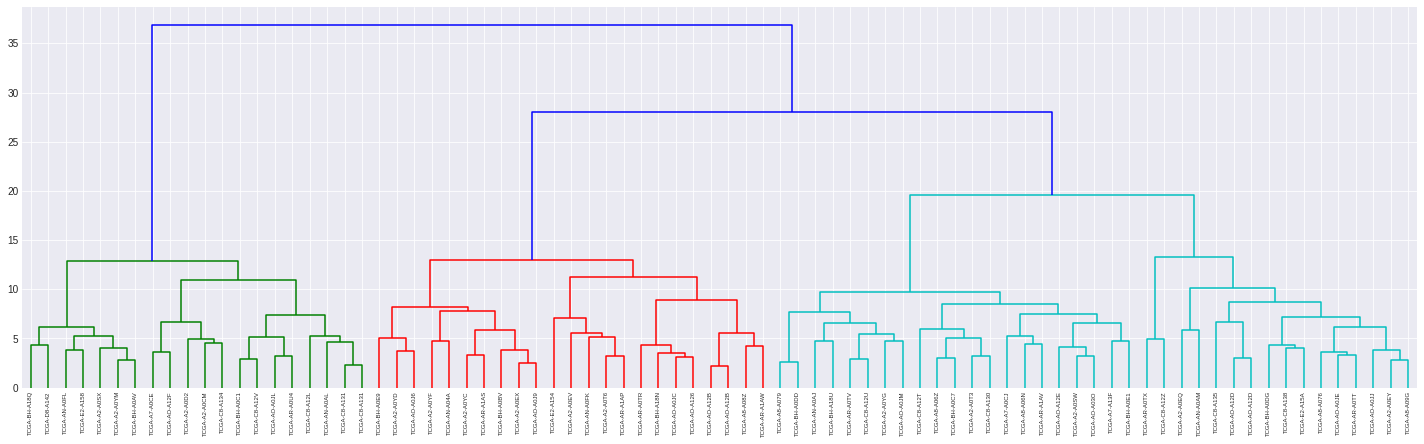

In [ ]:
plt.figure(figsize=(25,7))
dendrogram = sch.dendrogram(sch.linkage(scaled_proteome, method='ward'),labels=scaled_proteome.index)

In [ ]:
n_clusters = [2,3,4,5,6,7,8,10,15,27,40]

def compare_hierarchical(k_list,model):
    ## Run clustering with different k and check the metrics
    for k in k_list:
        clusterer = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
        clusterer.fit(model)
        ## The higher (up to 1) the better
        silhoutte = round(silhouette_score(model, clusterer.labels_), 4)
        print("Silhouette Coefficient for k == %s: %s" % (k, silhoutte))
        ## The higher (up to 1) the better
        homogenity = round(homogeneity_score(data['PAM50 mRNA'], clusterer.labels_),4)
        print("Homogeneity score for k == %s: %s" % (k,homogenity))
        rand= round(adjusted_rand_score(data['PAM50 mRNA'], clusterer.labels_),4)
        print("Ajusted Rand score for k == %s: %s" % (k,rand))
        # plt.scatter(model.iloc[:,0],model.iloc[:,1], c= clusterer.labels_, cmap='rainbow')
        # plt.show()
        print(f'Average : {round((silhoutte + homogenity + rand)/3,3)}')
        print("------------------------")

In [ ]:
compare_hierarchical(n_clusters,scaled_proteome)

Silhouette Coefficient for k == 2: 0.1609
Homogeneity score for k == 2: 0.1877
Ajusted Rand score for k == 2: 0.1569
Average : 0.168
------------------------
Silhouette Coefficient for k == 3: 0.132
Homogeneity score for k == 3: 0.4366
Ajusted Rand score for k == 3: 0.4267
Average : 0.332
------------------------
Silhouette Coefficient for k == 4: 0.122
Homogeneity score for k == 4: 0.4702
Ajusted Rand score for k == 4: 0.4403
Average : 0.344
------------------------
Silhouette Coefficient for k == 5: 0.1181
Homogeneity score for k == 5: 0.4874
Ajusted Rand score for k == 5: 0.3663
Average : 0.324
------------------------
Silhouette Coefficient for k == 6: 0.1116
Homogeneity score for k == 6: 0.5057
Ajusted Rand score for k == 6: 0.358
Average : 0.325
------------------------
Silhouette Coefficient for k == 7: 0.0933
Homogeneity score for k == 7: 0.5141
Ajusted Rand score for k == 7: 0.2907
Average : 0.299
------------------------
Silhouette Coefficient for k == 8: 0.091
Homogeneity sc

In [ ]:
final_model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
final_model.fit(pam50)
labels = final_model.labels_
labels

array([2, 2, 2, 0, 3, 1, 0, 2, 0, 0, 3, 0, 0, 1, 2, 2, 0, 1, 1, 0, 1, 0,
       3, 1, 0, 0, 2, 1, 3, 2, 0, 0, 3, 3, 1, 1, 2, 1, 3, 3, 3, 1, 1, 0,
       2, 3, 1, 1, 1, 2, 0, 3, 0, 3, 2, 0, 2, 0, 0, 1, 1, 0, 3, 2, 1, 2,
       1, 0, 2, 1, 0, 2, 2, 2, 1, 1, 2, 3, 2, 1])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


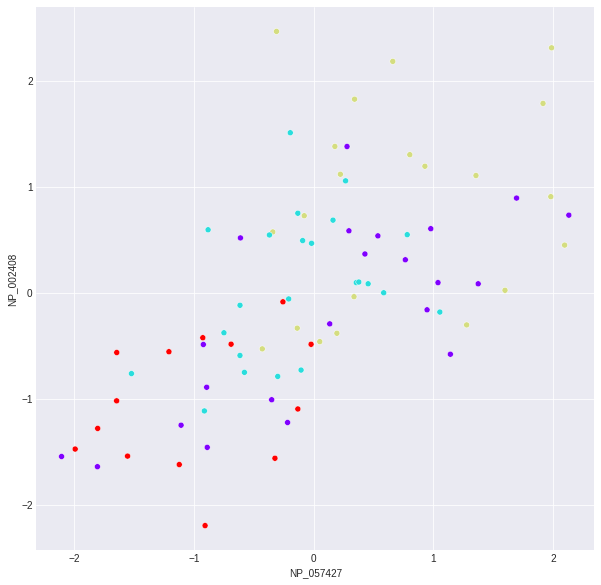

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(scaled_proteome.iloc[:,0],scaled_proteome.iloc[:,1], c=final_model.labels_, cmap='rainbow')

# DIMENSIONALITY REDUCTION - SVD

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
def Cluster(Array,Labels):
    N,M = Array.shape
    Dict = {}
    Ret = 0
    for i in range(M):
      Dict[i] = []
    for i in range(N):
      Id = 0
      Max = float('-inf')
      for j in range(M):
        if Max <= Array[i][j]:
          Max = Array[i][j]
          Id = j
      Dict[Id].append(Labels[i])
      counter = 0
    for i in Dict:
      counter += 1
      print(f"{counter} Count: {len(Dict[i])} Values:{Dict[i]} ")
      if len(Dict[i]) == 0:
        Ret += 1
    return Ret
      

In [ ]:
Flag = True
SVD_N = 1
for i in range(1,20):
  Zeros = Cluster(TruncatedSVD(n_components=i).fit_transform(scaled_proteome),scaled_proteome.index)
  if Zeros != 0 and Flag:
    Flag = False
    break
  SVD_N = i
  
  print()


1 Count: 80 Values:['TCGA-A2-A0CM', 'TCGA-A2-A0D2', 'TCGA-A2-A0EQ', 'TCGA-A2-A0EV', 'TCGA-A2-A0EX', 'TCGA-A2-A0EY', 'TCGA-A2-A0SW', 'TCGA-A2-A0SX', 'TCGA-A2-A0T3', 'TCGA-A2-A0T6', 'TCGA-A2-A0YC', 'TCGA-A2-A0YD', 'TCGA-A2-A0YF', 'TCGA-A2-A0YG', 'TCGA-A2-A0YM', 'TCGA-A7-A0CE', 'TCGA-A7-A0CJ', 'TCGA-A7-A13F', 'TCGA-A8-A06N', 'TCGA-A8-A06Z', 'TCGA-A8-A076', 'TCGA-A8-A079', 'TCGA-A8-A08Z', 'TCGA-A8-A09G', 'TCGA-AN-A04A', 'TCGA-AN-A0AJ', 'TCGA-AN-A0AL', 'TCGA-AN-A0AM', 'TCGA-AN-A0FK', 'TCGA-AN-A0FL', 'TCGA-AO-A03O', 'TCGA-AO-A0J6', 'TCGA-AO-A0J9', 'TCGA-AO-A0JC', 'TCGA-AO-A0JE', 'TCGA-AO-A0JJ', 'TCGA-AO-A0JL', 'TCGA-AO-A0JM', 'TCGA-AO-A126', 'TCGA-AO-A12B', 'TCGA-AO-A12B', 'TCGA-AO-A12D', 'TCGA-AO-A12D', 'TCGA-AO-A12E', 'TCGA-AO-A12F', 'TCGA-AR-A0TR', 'TCGA-AR-A0TT', 'TCGA-AR-A0TV', 'TCGA-AR-A0TX', 'TCGA-AR-A0U4', 'TCGA-AR-A1AP', 'TCGA-AR-A1AS', 'TCGA-AR-A1AV', 'TCGA-AR-A1AW', 'TCGA-BH-A0AV', 'TCGA-BH-A0BV', 'TCGA-BH-A0C1', 'TCGA-BH-A0C7', 'TCGA-BH-A0DD', 'TCGA-BH-A0DG', 'TCGA-BH-A0E1', 'TCG

In [ ]:
SVD = TruncatedSVD(n_components=SVD_N)

In [ ]:
SVD_N

11

In [ ]:
U = SVD.fit_transform(scaled_proteome)
U.shape

(80, 11)

In [ ]:
S = SVD.singular_values_
print(S)

[33.33157866 19.46931349 16.7647115  14.35906966 13.46456119 12.22234412
 11.20690449 11.06980875  9.80392319  9.27993293  8.95647143]


In [ ]:
V = SVD.components_
V.shape

(11, 42)

#MODELLING WITH HEIRARCHICAL CLUSTERING (After Dimentionality Reduction)

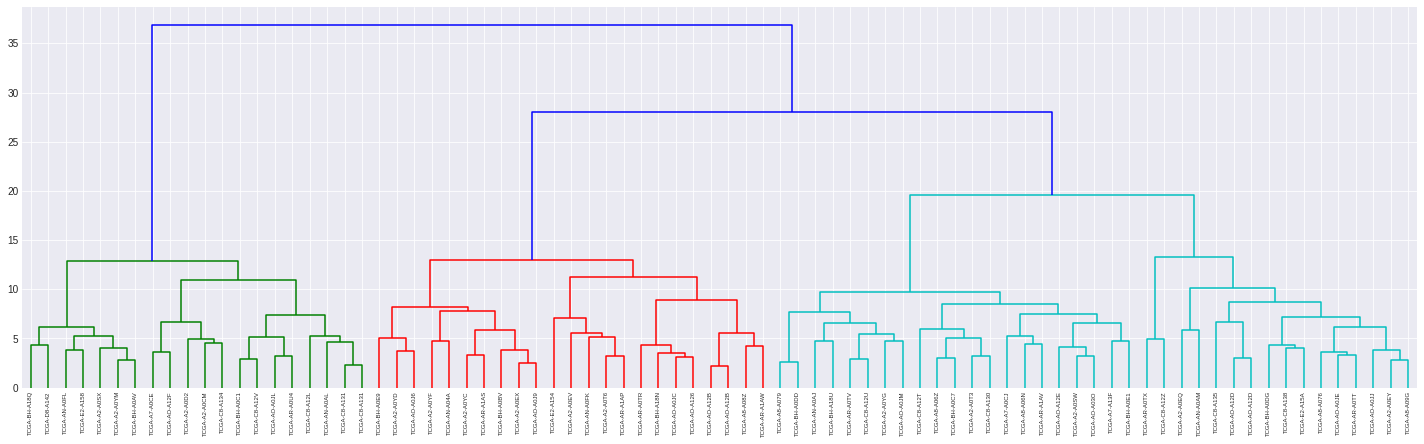

In [ ]:
plt.figure(figsize=(25,7))
dendrogram = sch.dendrogram(sch.linkage(U, method='ward'),labels=scaled_proteome.index)

In [ ]:
n_clusters = [2,3,4,5,6,7,8,10,15,27,40]

def compare_hierarchical(k_list,model):
    ## Run clustering with different k and check the metrics
    for k in k_list:
        clusterer = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
        clusterer.fit(model)
        ## The higher (up to 1) the better
        silhoutte = round(silhouette_score(model, clusterer.labels_), 4)
        print("Silhouette Coefficient for k == %s: %s" % (k, silhoutte))
        ## The higher (up to 1) the better
        homogenity = round(homogeneity_score(data['PAM50 mRNA'], clusterer.labels_),4)
        print("Homogeneity score for k == %s: %s" % (k,homogenity))
        rand= round(adjusted_rand_score(data['PAM50 mRNA'], clusterer.labels_),4)
        print("Ajusted Rand score for k == %s: %s" % (k,rand))
        # plt.scatter(model.iloc[:,0],model.iloc[:,1], c= clusterer.labels_, cmap='rainbow')
        # plt.show()
        print(f'Average : {round((silhoutte + homogenity + rand)/3,3)}')
        print("------------------------")

In [ ]:
compare_hierarchical(n_clusters,U)

Silhouette Coefficient for k == 2: 0.2373
Homogeneity score for k == 2: 0.3076
Ajusted Rand score for k == 2: 0.2858
Average : 0.277
------------------------
Silhouette Coefficient for k == 3: 0.2077
Homogeneity score for k == 3: 0.478
Ajusted Rand score for k == 3: 0.4637
Average : 0.383
------------------------
Silhouette Coefficient for k == 4: 0.2101
Homogeneity score for k == 4: 0.5415
Ajusted Rand score for k == 4: 0.5172
Average : 0.423
------------------------
Silhouette Coefficient for k == 5: 0.2064
Homogeneity score for k == 5: 0.5509
Ajusted Rand score for k == 5: 0.5081
Average : 0.422
------------------------
Silhouette Coefficient for k == 6: 0.1794
Homogeneity score for k == 6: 0.581
Ajusted Rand score for k == 6: 0.4506
Average : 0.404
------------------------
Silhouette Coefficient for k == 7: 0.1599
Homogeneity score for k == 7: 0.5895
Ajusted Rand score for k == 7: 0.3679
Average : 0.372
------------------------
Silhouette Coefficient for k == 8: 0.1665
Homogeneity 

In [ ]:
final_model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
final_model.fit(U)
labels = final_model.labels_
labels

array([1, 1, 0, 2, 2, 0, 3, 1, 3, 2, 2, 2, 2, 3, 1, 1, 3, 3, 3, 3, 0, 3,
       2, 0, 2, 3, 1, 0, 2, 1, 3, 2, 2, 2, 0, 0, 1, 3, 2, 2, 2, 0, 0, 3,
       1, 2, 0, 3, 0, 1, 2, 2, 3, 2, 1, 2, 1, 3, 3, 0, 3, 2, 2, 1, 3, 1,
       3, 3, 1, 0, 3, 1, 1, 1, 0, 0, 1, 2, 1, 0])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


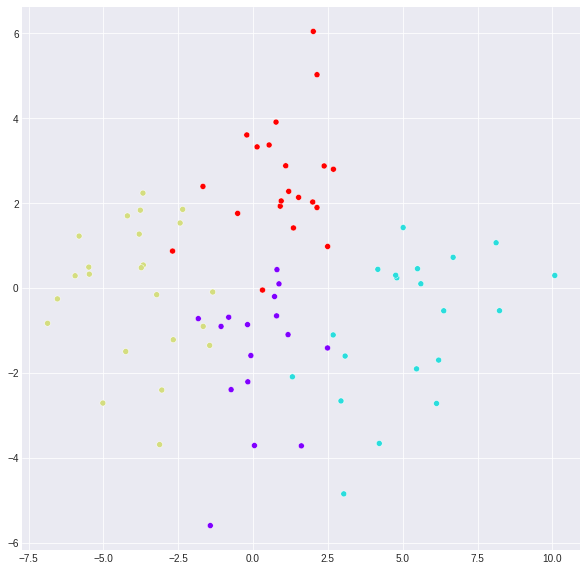

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(U[:,0],U[:,1], c=final_model.labels_, cmap='rainbow')

#**SUPERVISED LEARNING**

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['PAM50 mRNA_'] = le.fit_transform(data['PAM50 mRNA'])

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = scaled_proteome
Y = data['PAM50 mRNA_']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [ ]:
X_train.shape,X_test.shape

((72, 41), (8, 41))

In [ ]:
data['PAM50 mRNA'].value_counts()

Luminal B        25
Luminal A        23
Basal-like       19
HER2-enriched    13
Name: PAM50 mRNA, dtype: int64

# LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train,Y_train)

LogisticRegression()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
model.score(X_test,Y_test)

0.625

# DECISION TREE

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
DT = DecisionTreeClassifier(criterion="entropy",max_depth=4)
DT.fit(X_train,Y_train)

In [ ]:
y_pred = DT.predict(X_test)

In [ ]:
DT.score(X_test,Y_test)

In [ ]:
print(confusion_matrix(Y_test,y_pred))
print(classification_report(Y_test,y_pred))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
DT1 = DecisionTreeClassifier()
DT1.fit(X_train,Y_train)

In [ ]:
y_pred = DT1.predict(X_test)

In [ ]:
DT1.score(X_test,Y_test)

In [ ]:
print(confusion_matrix(Y_test,y_pred))
print(classification_report(Y_test,y_pred))